In [63]:
import os
import random

import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub

from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Corrected import
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

In [64]:
dataset_path = "dataset_padang_food"

class_names = os.listdir(dataset_path)

class_names

['ayam_goreng',
 'ayam_pop',
 'daging_rendang',
 'dendeng_batokok',
 'gulai_ikan',
 'gulai_tambusu',
 'gulai_tunjang',
 'telur_balado',
 'telur_dadar']

In [65]:
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f"{class_name}: {num_images} images")


ayam_goreng: 117 images
ayam_pop: 113 images
daging_rendang: 104 images
dendeng_batokok: 120 images
gulai_ikan: 111 images
gulai_tambusu: 103 images
gulai_tunjang: 119 images
telur_balado: 111 images
telur_dadar: 116 images


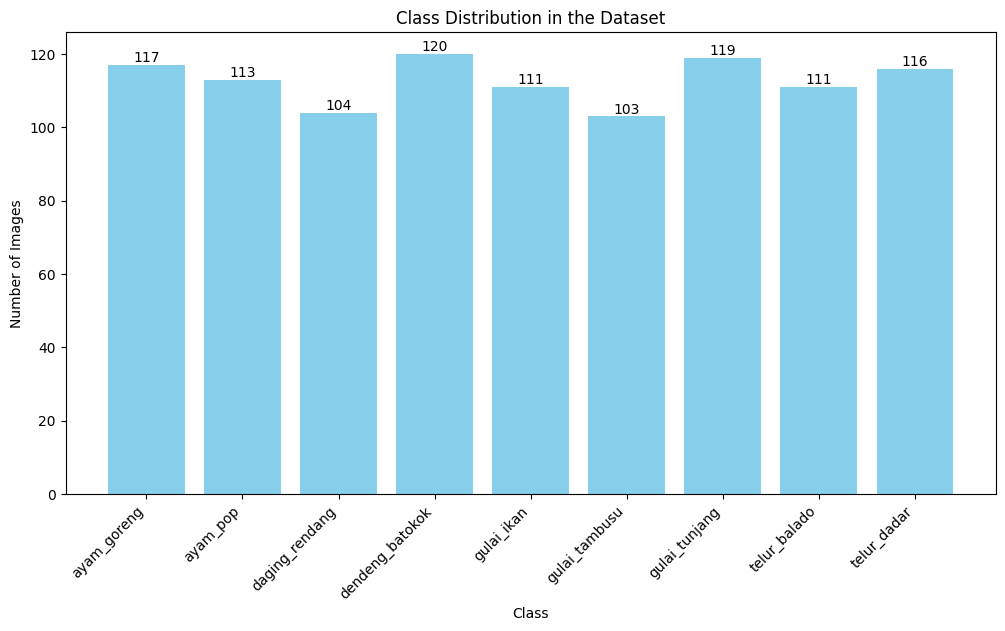

In [66]:
class_counts = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in class_names}

plt.figure(figsize=(12, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in the Dataset')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')

plt.show()


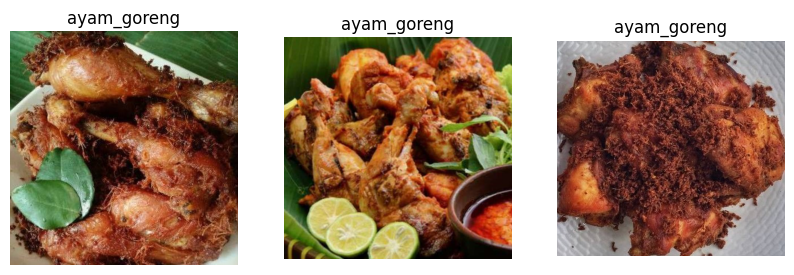

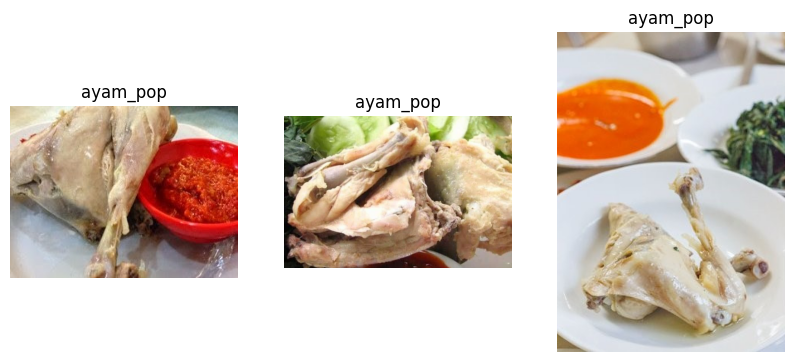

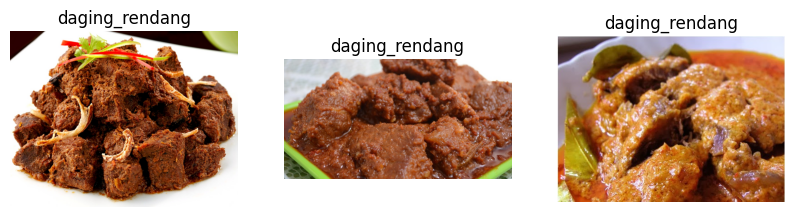

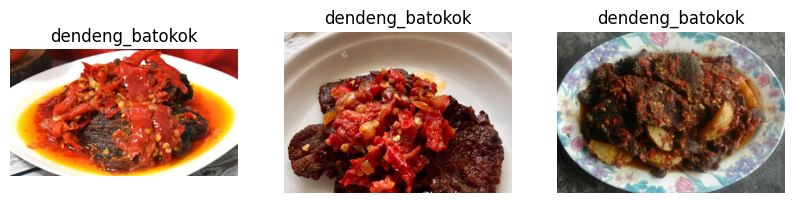

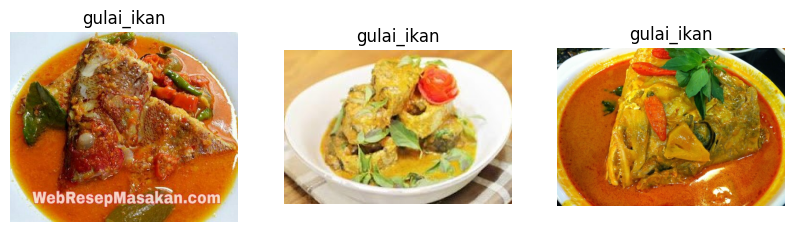

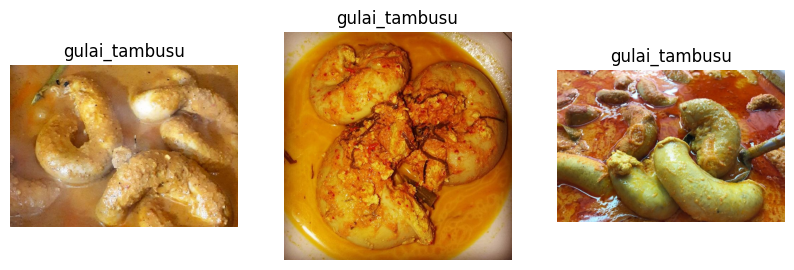

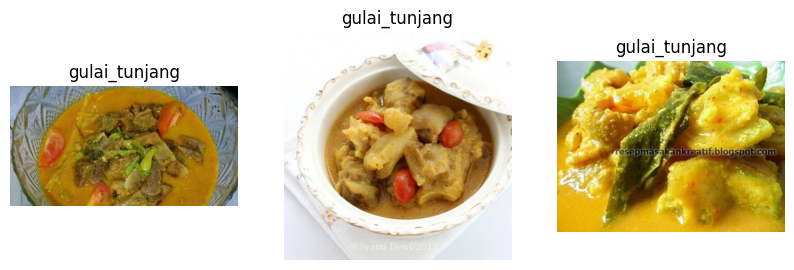

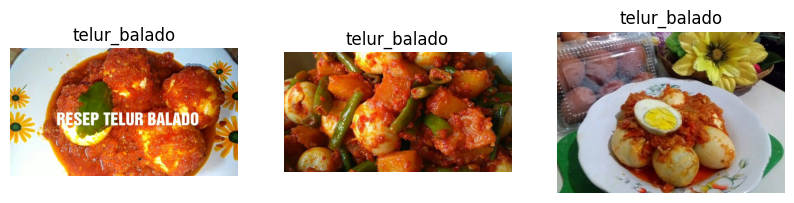

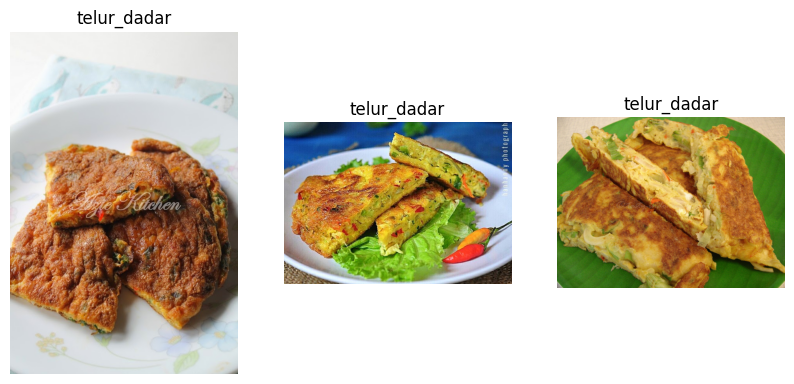

In [67]:
num_samples = 3

for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)
    sample_images = random.sample(image_files, num_samples)

    plt.figure(figsize=(10, 5))
    for i, image_file in enumerate(sample_images, 1):
        img_path = os.path.join(class_path, image_file)
        img = plt.imread(img_path)

        plt.subplot(1, num_samples, i)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.show()

In [68]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [69]:
ssd_head = models.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(len(class_names) + 4, activation='softmax')
])

In [70]:
model = models.Sequential([
    base_model,
    ssd_head
])

In [71]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [72]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

In [73]:
datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input)

In [74]:
batch_size = 32

In [75]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

Found 815 images belonging to 9 classes.


In [76]:
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
)

Found 199 images belonging to 9 classes.


In [77]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

In [78]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [79]:
history = model.fit(
    train_generator,
    epochs=200,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/200
25/25 [==============================] - 23s 837ms/step - loss: 7.0366 - accuracy: 0.1354 - val_loss: 6.3299 - val_accuracy: 0.2500
Epoch 2/200
25/25 [==============================] - 21s 845ms/step - loss: 6.2872 - accuracy: 0.2503 - val_loss: 5.8609 - val_accuracy: 0.4740
Epoch 3/200
25/25 [==============================] - 21s 827ms/step - loss: 5.9482 - accuracy: 0.3525 - val_loss: 5.4834 - val_accuracy: 0.5938
Epoch 4/200
25/25 [==============================] - 21s 833ms/step - loss: 5.6095 - accuracy: 0.4432 - val_loss: 5.2289 - val_accuracy: 0.6458
Epoch 5/200
25/25 [==============================] - 22s 859ms/step - loss: 5.2900 - accuracy: 0.5402 - val_loss: 5.0098 - val_accuracy: 0.6927
Epoch 6/200
25/25 [==============================] - 21s 859ms/step - loss: 5.0508 - accuracy: 0.5811 - val_loss: 4.7403 - val_accuracy: 0.7552
Epoch 7/200
25/25 [==============================] - 21s 854ms/step - loss: 4.8909 - accuracy: 0.6156 - val_loss: 4.5842 - val_accuracy:

In [80]:
test_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 199 images belonging to 9 classes.


In [81]:
predictions = model.predict(test_generator)

true_labels = test_generator.labels

predicted_labels = np.argmax(predictions, axis=1)

test_accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Test Accuracy: {test_accuracy}')

7/7 [==============================] - 4s 512ms/step
Test Accuracy: 0.8743718592964824


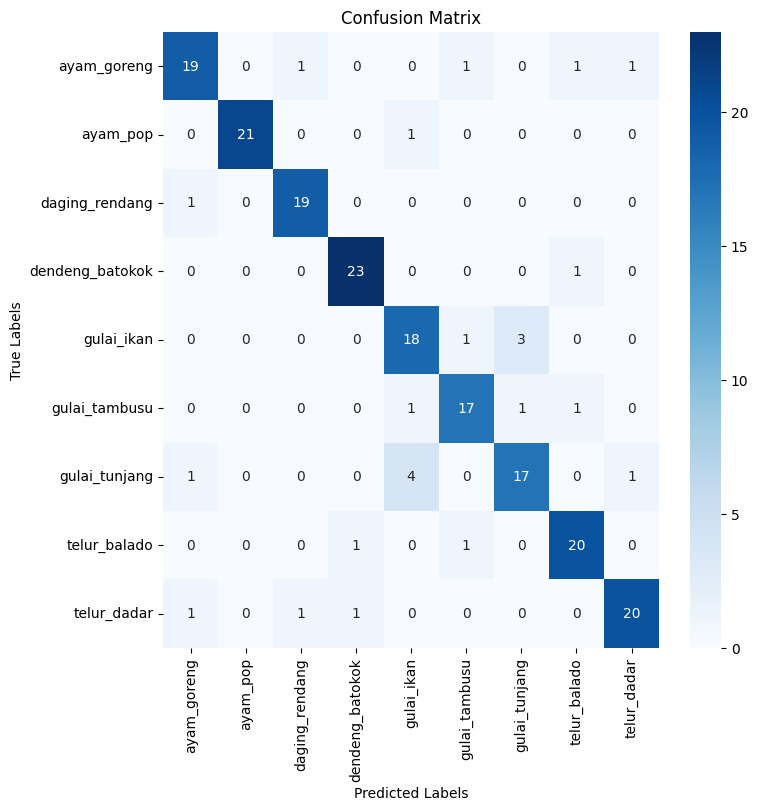

In [82]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

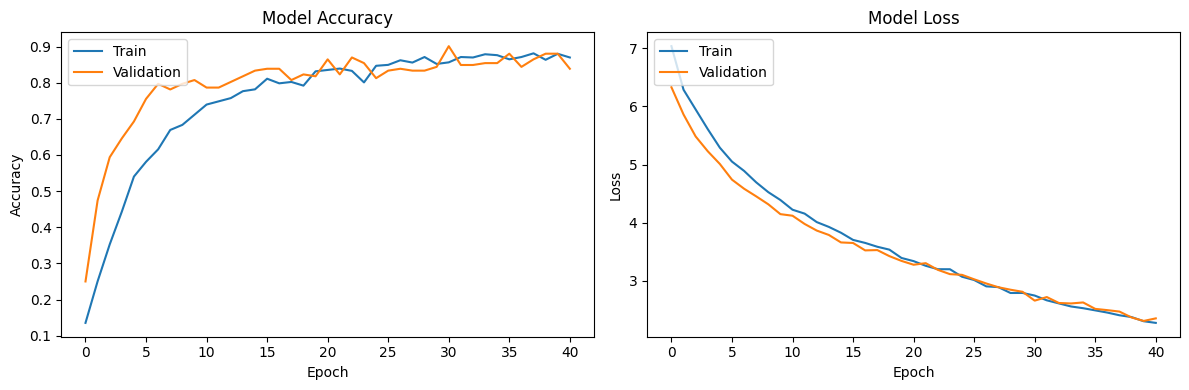

In [83]:
# Plot the training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [84]:
test_dataset_path = "data tes"

In [85]:
test_image_files = [os.path.join(test_dataset_path, img) for img in os.listdir(test_dataset_path)]

In [86]:
def preprocess_user_input(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [87]:
def evaluate_model(model, validation_generator, class_names):
    y_true_all = []
    y_pred_all = []

    for img_path in validation_generator.filepaths:
        # Preprocess validation image
        val_img = preprocess_user_input(img_path)

        # Make predictions without showing the progress bar
        predictions = model.predict(val_img, verbose=0)

        # Get the predicted class index
        predicted_class_index = np.argmax(predictions)

        # Get the true class index
        true_class_index = validation_generator.class_indices[os.path.basename(os.path.dirname(img_path))]

        # Append to the lists
        y_true_all.append(true_class_index)
        y_pred_all.append(predicted_class_index)

    # Convert class indices to class names
    y_true_classnames = [class_names[idx] for idx in y_true_all]
    y_pred_classnames = [class_names[idx] for idx in y_pred_all]

    # Classification Report
    class_report = classification_report(y_true_classnames, y_pred_classnames, target_names=class_names)

    # Print Classification Report
    print(class_report)

# Call the function to evaluate the model
evaluate_model(model, validation_generator, class_names)


                 precision    recall  f1-score   support

    ayam_goreng       1.00      0.83      0.90        23
       ayam_pop       1.00      0.95      0.98        22
 daging_rendang       0.95      1.00      0.98        20
dendeng_batokok       1.00      1.00      1.00        24
     gulai_ikan       0.81      0.77      0.79        22
  gulai_tambusu       0.80      0.80      0.80        20
  gulai_tunjang       0.74      0.87      0.80        23
   telur_balado       0.91      0.95      0.93        22
    telur_dadar       0.96      0.96      0.96        23

       accuracy                           0.90       199
      macro avg       0.91      0.90      0.90       199
   weighted avg       0.91      0.90      0.91       199



1/1 [==============================] - 0s 41ms/step


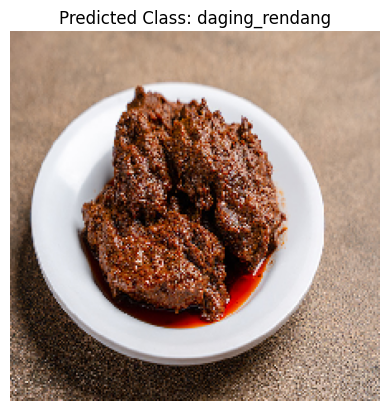

1/1 [==============================] - 0s 36ms/step


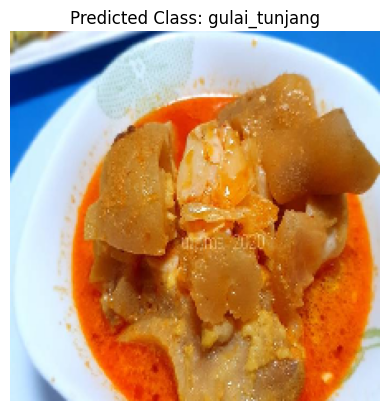

1/1 [==============================] - 0s 41ms/step


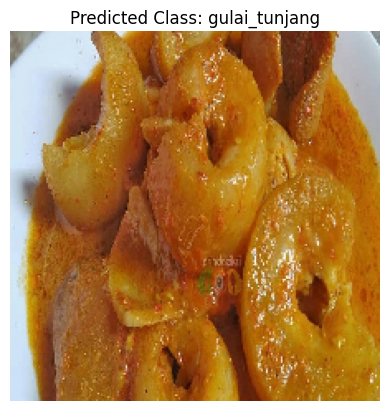

1/1 [==============================] - 0s 41ms/step


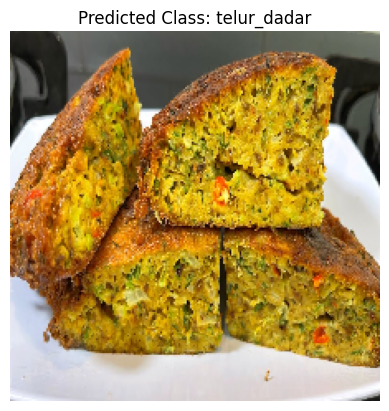

1/1 [==============================] - 0s 37ms/step


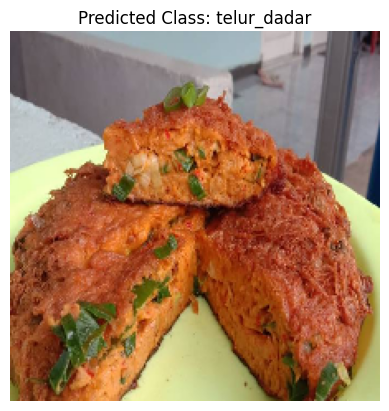

1/1 [==============================] - 0s 68ms/step


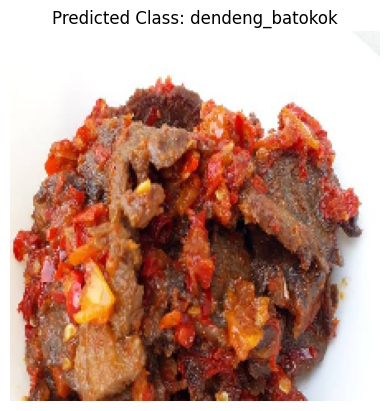

1/1 [==============================] - 0s 39ms/step


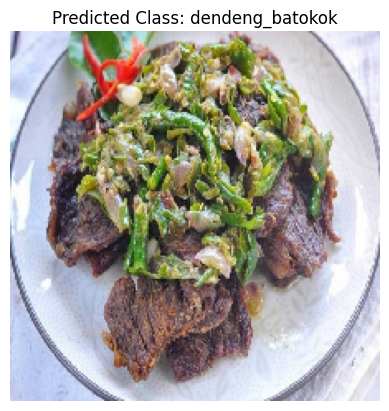

1/1 [==============================] - 0s 50ms/step


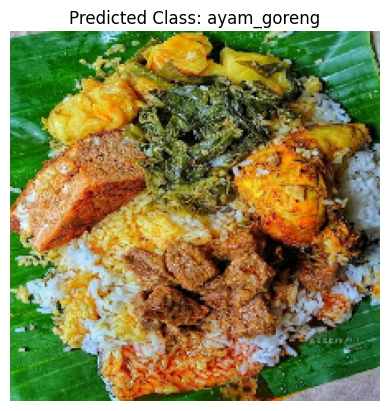

1/1 [==============================] - 0s 42ms/step


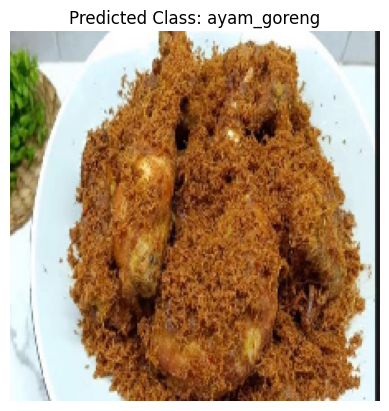

1/1 [==============================] - 0s 45ms/step


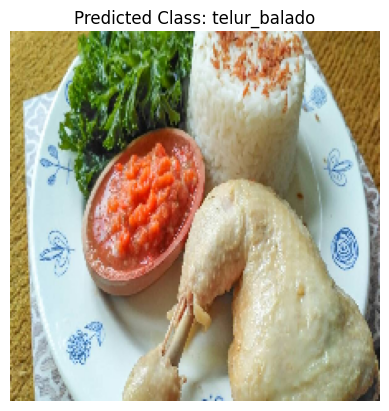

1/1 [==============================] - 0s 38ms/step


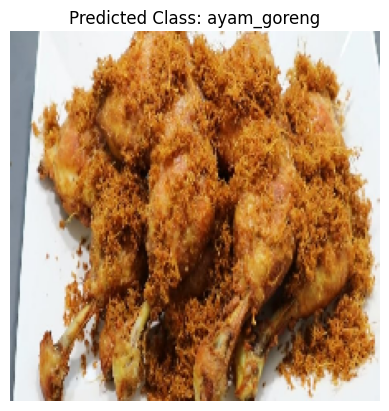

1/1 [==============================] - 0s 45ms/step


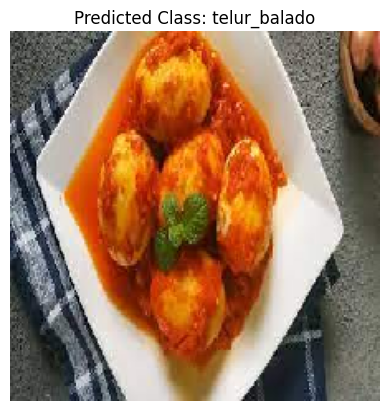

1/1 [==============================] - 0s 37ms/step


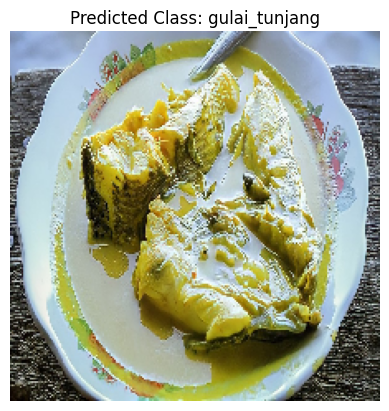

1/1 [==============================] - 0s 37ms/step


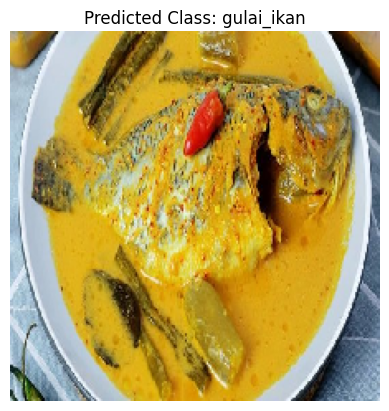

1/1 [==============================] - 0s 40ms/step


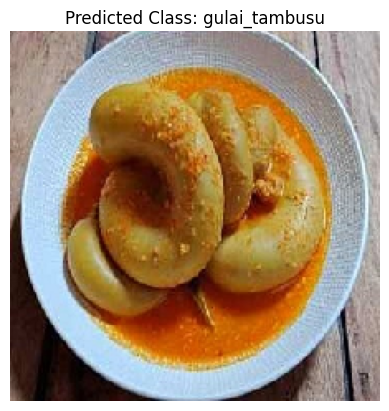

1/1 [==============================] - 0s 45ms/step


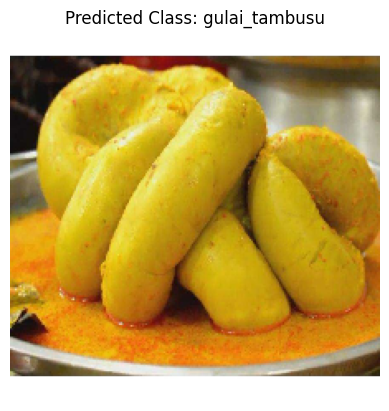

1/1 [==============================] - 0s 42ms/step


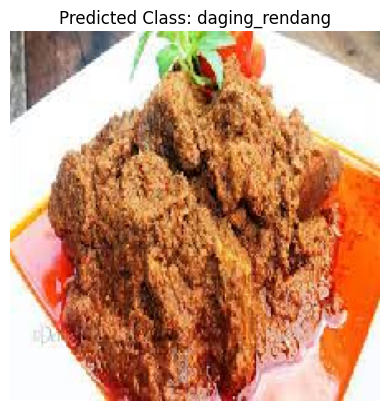

In [ ]:
# Loop through each test image and make predictions
for img_path in test_image_files:
    # Preprocess test image
    test_img = preprocess_user_input(img_path)

    # Make predictions
    predictions = model.predict(test_img)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)

    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]

    # Display the image along with the prediction
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Class: {predicted_class_name}")
    plt.show()